In [2]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [4]:
# 파일들이 있는 폴더 경로
folder_path = 'C:/Users/mumu1/Desktop/project_movie_data/project_dataset'

# 파일 이름을 변수에 할당
o_df_customers = pd.read_csv(os.path.join(folder_path, 'olist_customers_dataset.csv'), encoding='ISO-8859-1')
o_df_geolocation = pd.read_csv(os.path.join(folder_path, 'olist_geolocation_dataset.csv'), encoding='ISO-8859-1')
o_df_order_items = pd.read_csv(os.path.join(folder_path, 'olist_order_items_dataset.csv'), encoding='ISO-8859-1')
o_df_order_payments = pd.read_csv(os.path.join(folder_path, 'olist_order_payments_dataset.csv'), encoding='ISO-8859-1')
o_df_order_reviews = pd.read_csv(os.path.join(folder_path, 'olist_order_reviews_dataset.csv'), encoding='ISO-8859-1')
o_df_products = pd.read_csv(os.path.join(folder_path, 'olist_products_dataset.csv'), encoding='ISO-8859-1')
o_df_sellers = pd.read_csv(os.path.join(folder_path, 'olist_sellers_dataset.csv'), encoding='ISO-8859-1')
o_df_product_category_name_translation = pd.read_csv(os.path.join(folder_path, 'product_category_name_translation.csv'), encoding='utf-8-sig')
o_df_orders = pd.read_csv(os.path.join(folder_path, 'olist_orders_dataset.csv'), encoding='ISO-8859-1')

print("✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.")

# 카피본 생성
df_customers = o_df_customers.copy()
df_geolocation = o_df_geolocation.copy()
df_order_items = o_df_order_items.copy()
df_order_payments = o_df_order_payments.copy()
df_order_reviews = o_df_order_reviews.copy()
df_products = o_df_products.copy()
df_sellers = o_df_sellers.copy()
df_product_category_name_translation = o_df_product_category_name_translation.copy()
df_order = o_df_orders.copy()

✅ 모든 파일이 개별적으로 메모리에 로드되었습니다.


In [5]:
# 이상치 탐색
dfs = {
    "customers": df_customers,
    "geolocation": df_geolocation,
    "order_items": df_order_items,
    "order_payments": df_order_payments,
    "order_reviews": df_order_reviews,
    "orders": df_order,
    "products": df_products,
    "sellers": df_sellers,
    "product_category": df_product_category_name_translation
}

# 0, 음수 비율 + IQR 이상치 탐색 함수
def check_data_quality(df, name):
    print(f"\n===== {name} =====")
    num_cols = df.select_dtypes(include="number").columns
    if len(num_cols) == 0:
        print("수치형 컬럼 없음")
        return
    for col in num_cols:
        total = len(df)

        # 0 / 음수 비율
        zero_ratio = (df[col] == 0).sum() / total * 100
        neg_ratio = (df[col] < 0).sum() / total * 100

        # IQR 이상치 비율
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        outlier_ratio = ((df[col] < lower) | (df[col] > upper)).sum() / total * 100

        # 출력
        if zero_ratio > 0 or neg_ratio > 0 or outlier_ratio > 0:
            print(f"- {col}: 0 비율={zero_ratio:.2f}%, 음수 비율={neg_ratio:.2f}%, 이상치 비율={outlier_ratio:.2f}%")

# 실행
for name, df in dfs.items():
    check_data_quality(df, name)



===== customers =====

===== geolocation =====
- geolocation_lat: 0 비율=0.00%, 음수 비율=99.87%, 이상치 비율=16.82%
- geolocation_lng: 0 비율=0.00%, 음수 비율=100.00%, 이상치 비율=4.23%

===== order_items =====
- order_item_id: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=12.41%
- price: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=7.48%
- freight_value: 0 비율=0.34%, 음수 비율=0.00%, 이상치 비율=10.77%

===== order_payments =====
- payment_sequential: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=4.36%
- payment_installments: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=6.08%
- payment_value: 0 비율=0.01%, 음수 비율=0.00%, 이상치 비율=7.68%

===== order_reviews =====
- review_score: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=14.69%

===== orders =====
수치형 컬럼 없음

===== products =====
- product_name_lenght: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=0.88%
- product_description_lenght: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=6.31%
- product_photos_qty: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=2.58%
- product_weight_g: 0 비율=0.01%, 음수 비율=0.00%, 이상치 비율=13.81%
- product_length_cm: 0 비율=0.00%, 음수 비율=0.00%, 이상치 비율=4.19%
- pr

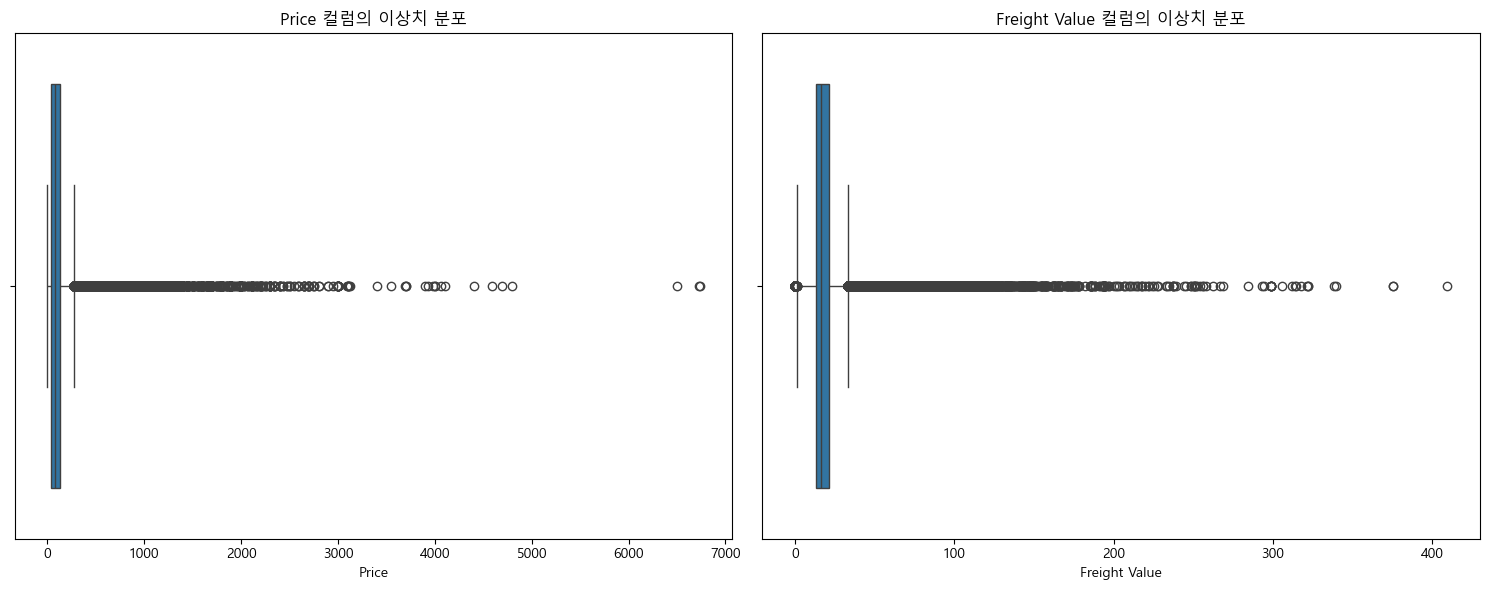

In [6]:
# 이상치 확인: order_item['price'],['fight_value]: 시각화
# 고가의 구매제품 존재, 
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. price 컬럼
sns.boxplot(x=df_order_items['price'], ax=axes[0])
axes[0].set_title('Price 컬럼의 이상치 분포')
axes[0].set_xlabel('Price')

# 2. freight_value 컬럼의 상자 그림
sns.boxplot(x=df_order_items['freight_value'], ax=axes[1])
axes[1].set_title('Freight Value 컬럼의 이상치 분포')
axes[1].set_xlabel('Freight Value')

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

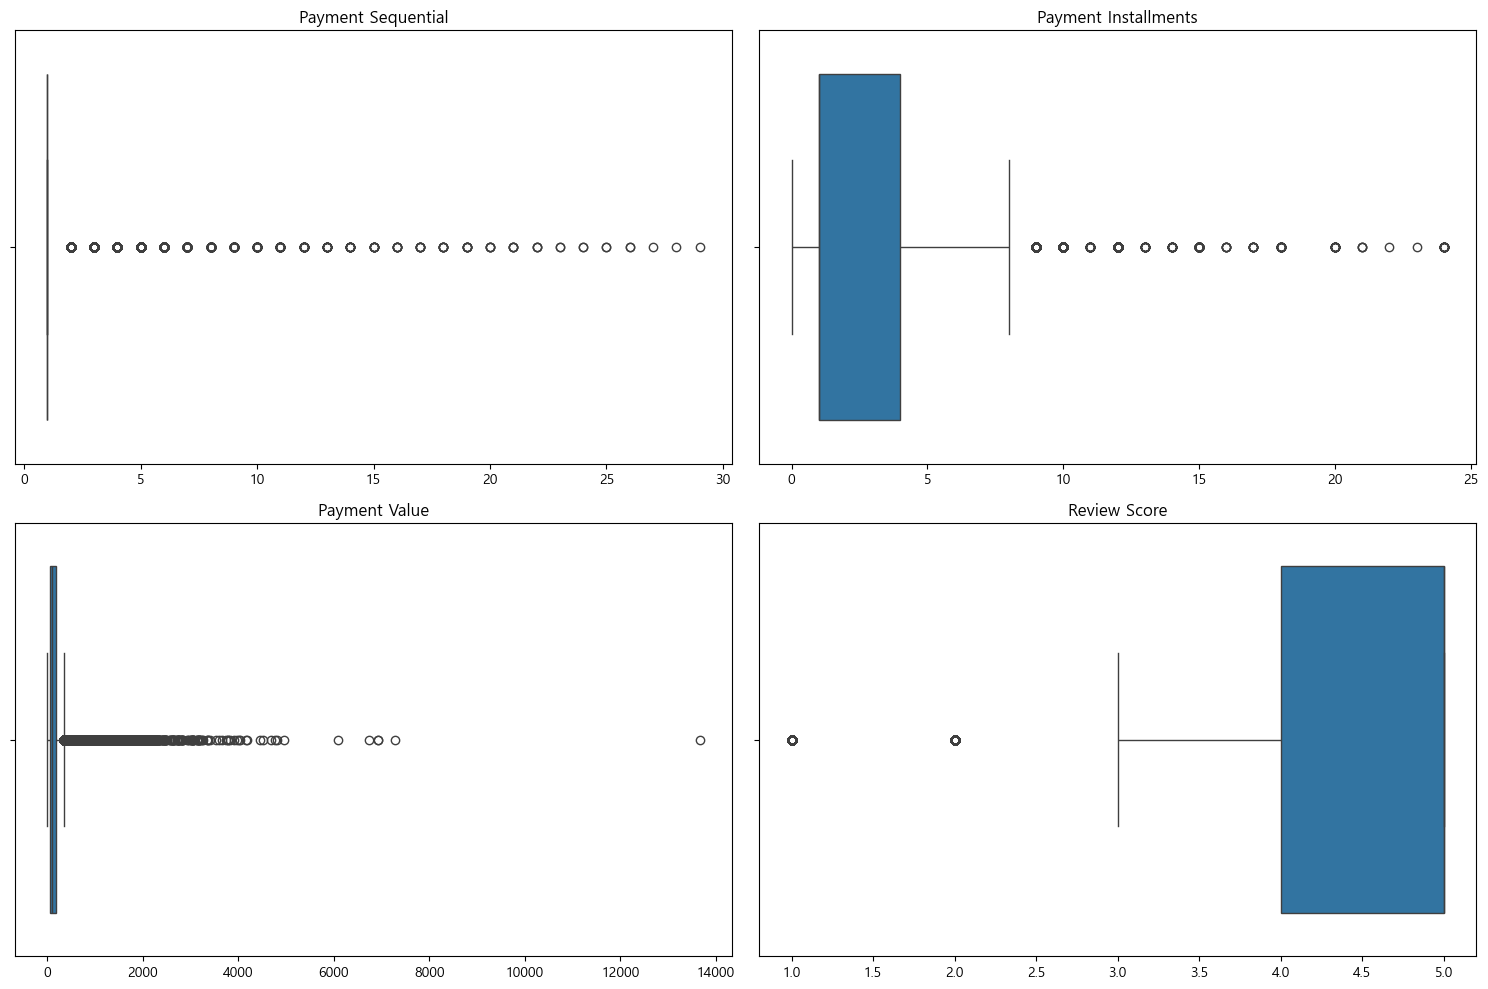

In [7]:
# 이상치 시각화: 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. payment_sequential
sns.boxplot(x=df_order_payments['payment_sequential'], ax=axes[0, 0])
axes[0, 0].set_title('Payment Sequential')
axes[0, 0].set_xlabel('')

# 2. payment_installments
sns.boxplot(x=df_order_payments['payment_installments'], ax=axes[0, 1])
axes[0, 1].set_title('Payment Installments')
axes[0, 1].set_xlabel('')

# 3. payment_value
sns.boxplot(x=df_order_payments['payment_value'], ax=axes[1, 0])
axes[1, 0].set_title('Payment Value')
axes[1, 0].set_xlabel('')

# 4. review_score
sns.boxplot(x=df_order_reviews['review_score'], ax=axes[1, 1])
axes[1, 1].set_title('Review Score')
axes[1, 1].set_xlabel('')

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [8]:
# payment_sequential 이상치 확인

# payment_sequential = 29 인 주문 찾기
# seq_29_orders = df_order_payments[df_order_payments['payment_sequential'] == 29]['order_id'].unique()
# print("payment_sequential=29 주문 수:", len(seq_29_orders))

# 해당 주문 상세 결제 내역 확인
# df_seq_29 = df_order_payments[df_order_payments['order_id'].isin(seq_29_orders)]
# df_seq_29 = df_seq_29.sort_values(['order_id','payment_sequential'])
# print(df_seq_29.head(20))

# 1) payment_sequential ≥ 10인 주문 ID 추출
hi_seq_orders = (
    df_order_payments.loc[df_order_payments["payment_sequential"] >= 10, "order_id"]
    .unique()
)

# 2) 해당 주문들의 결제 상세 내역 추출
hi_seq_details = (
    df_order_payments[df_order_payments["order_id"].isin(hi_seq_orders)]
    .copy()
)

# 3) 결제ID 단위 그룹핑 (order_id + payment_sequential)
grouped_by_payment = (
    hi_seq_details
    .groupby(["order_id", "payment_sequential"], as_index=False)
    .agg(
        payment_type=("payment_type", "first"),
        installments=("payment_installments", "first"),
        value_sum=("payment_value", "sum"),
        record_count=("payment_value", "count")
    )
    .sort_values(["order_id", "payment_sequential"])
)

print("=== 결제ID 단위 그룹핑 (상위 20행) ===")
print(grouped_by_payment.head(20))

# 4) 주문 단위 요약 (결제 건수, 합계)
summary_by_order = (
    grouped_by_payment
    .groupby("order_id", as_index=False)
    .agg(
        payments_cnt=("payment_sequential", "max"),
        payment_sum=("value_sum", "sum")
    )
    .sort_values("payments_cnt", ascending=False)
)

print("\n=== 주문 단위 요약 (Top 10) ===")
print(summary_by_order.head(10))

=== 결제ID 단위 그룹핑 (상위 20행) ===
                            order_id  payment_sequential payment_type  \
0   0bbb3f7791a87d0307555e57da3a1ff1                   1  credit_card   
1   0bbb3f7791a87d0307555e57da3a1ff1                   2      voucher   
2   0bbb3f7791a87d0307555e57da3a1ff1                   3      voucher   
3   0bbb3f7791a87d0307555e57da3a1ff1                   4      voucher   
4   0bbb3f7791a87d0307555e57da3a1ff1                   5      voucher   
5   0bbb3f7791a87d0307555e57da3a1ff1                   6      voucher   
6   0bbb3f7791a87d0307555e57da3a1ff1                   7      voucher   
7   0bbb3f7791a87d0307555e57da3a1ff1                   8      voucher   
8   0bbb3f7791a87d0307555e57da3a1ff1                   9      voucher   
9   0bbb3f7791a87d0307555e57da3a1ff1                  10      voucher   
10  0bbb3f7791a87d0307555e57da3a1ff1                  11      voucher   
11  1a611328643ae11146ba09a4425d2e12                   1  credit_card   
12  1a611328643ae11146

In [9]:
# 8개 데이터프레임의 결측값 분석
def check_missing(dfs, df_names):
    for df, name in zip(dfs, df_names):
        print(f"\n📊 {name} 데이터프레임 결측값 분석")
        
        missing_info = df.isnull().sum()
        m_pct = (missing_info / len(df)) * 100
        
        if missing_info.sum() == 0:
            print("✅ 결측값 없음. 완전")
        else:
            print("⚠️ 결측치 존재")
            missing_sum = pd.DataFrame({
                '결측수': missing_info,
                '결측율(%)': m_pct,
            }).round(2)
            missing_sum = missing_sum[missing_sum['결측수'] > 0]
            display(missing_sum)

# 사용 예시
original_dfs = [ 
    o_df_customers, o_df_geolocation, o_df_order_items,
    o_df_order_payments, o_df_order_reviews, o_df_products,
    o_df_sellers, o_df_product_category_name_translation,
]

df_names = [
    "customers", "geolocation", "order_items",
    "order_payments", "order_reviews", "products",
    "sellers", "product_category_name_translation",
]

check_missing(original_dfs, df_names)


📊 customers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 geolocation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_items 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_payments 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 order_reviews 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
review_comment_title,87656,88.34
review_comment_message,58247,58.70



📊 products 데이터프레임 결측값 분석
⚠️ 결측치 존재


,결측수,결측율(%)
product_category_name,610,1.85
product_name_lenght,610,1.85
product_description_lenght,610,1.85
product_photos_qty,610,1.85
product_weight_g,2,0.01
product_length_cm,2,0.01
product_height_cm,2,0.01
product_width_cm,2,0.01



📊 sellers 데이터프레임 결측값 분석
✅ 결측값 없음. 완전

📊 product_category_name_translation 데이터프레임 결측값 분석
✅ 결측값 없음. 완전


# 전처리

In [10]:
# df_products #32951

# 결측치 보존: 2448
# 이상치: 음수 없음, '0' 보존
# 마이너스 값 없음

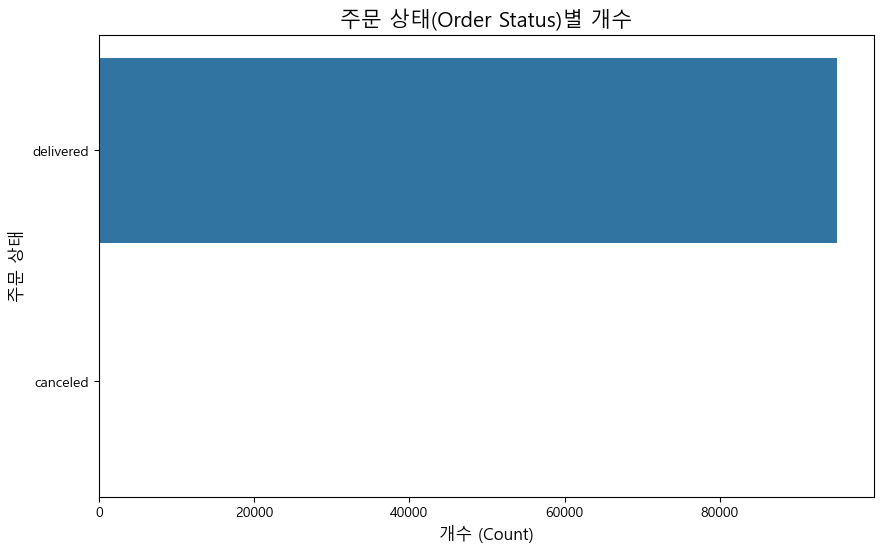

C:\Users\mumu1\AppData\Local\Temp\ipykernel_8708\2025754651.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order[col] = pd.to_datetime(df_order[col], errors='coerce')
C:\Users\mumu1\AppData\Local\Temp\ipykernel_8708\2025754651.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order[col] = pd.to_datetime(df_order[col], errors='coerce')
C:\Users\mumu1\AppData\Local\Temp\ipykernel_8708\2025754651.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

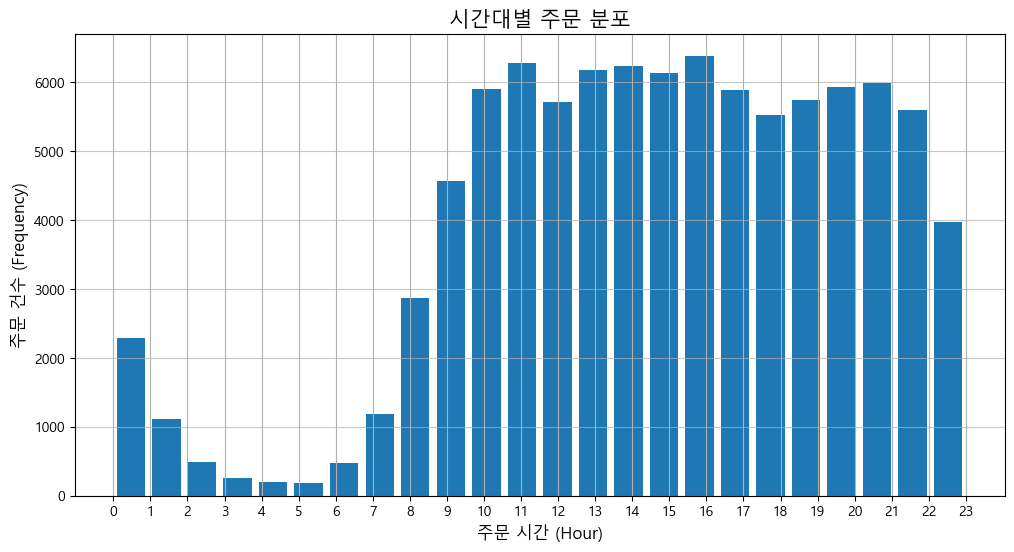

C:\Users\mumu1\AppData\Local\Temp\ipykernel_8708\2025754651.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order['purchase_to_approved'] = (df_order['order_approved_at'] - df_order['order_purchase_timestamp']).dt.total_seconds() / 86400
C:\Users\mumu1\AppData\Local\Temp\ipykernel_8708\2025754651.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order['approved_to_carrier'] = (df_order['order_delivered_carrier_date'] - df_order['order_approved_at']).dt.total_seconds() / 86400
C:\Users\mumu1\Ap

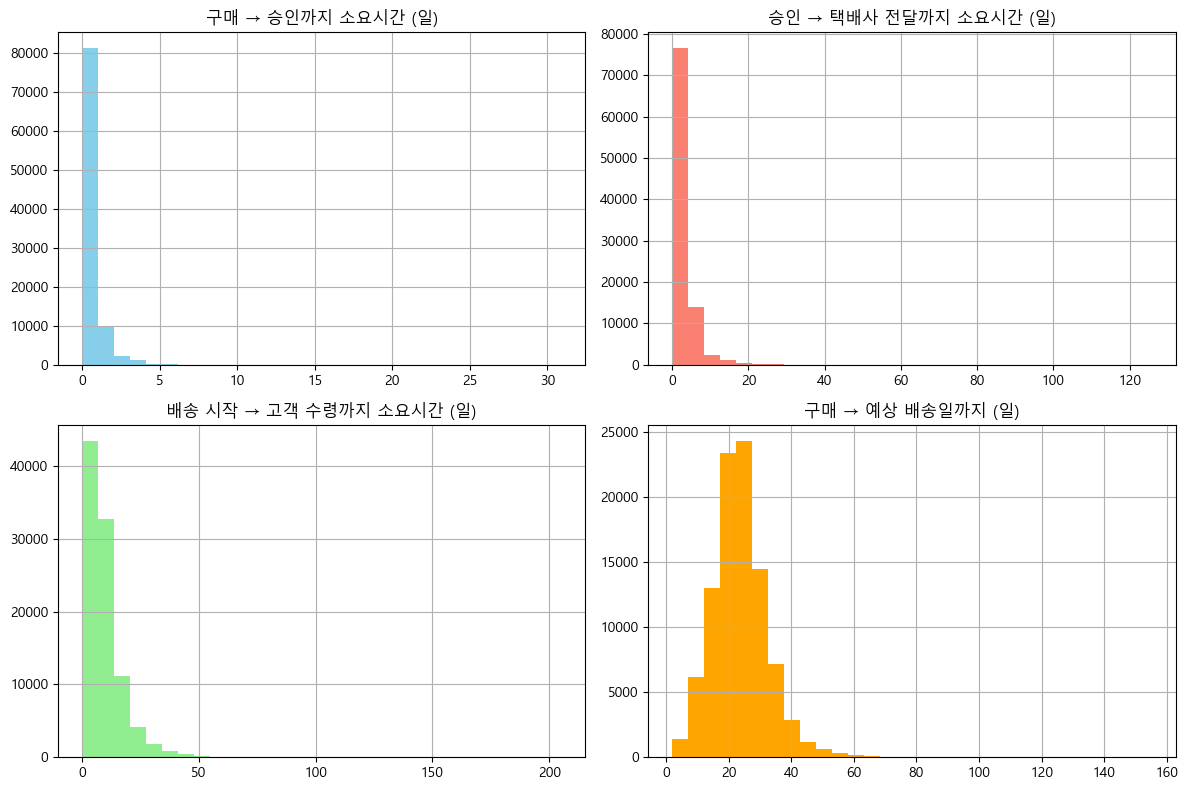

C:\Users\mumu1\AppData\Local\Temp\ipykernel_8708\2025754651.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])
C:\Users\mumu1\AppData\Local\Temp\ipykernel_8708\2025754651.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_order['day_of_week'] = df_order['order_purchase_timestamp'].dt.dayofweek
C:\Users\mumu1\AppData\Local\Temp\ipykernel_8708\2025754651.py:67: SettingWithCopyWarning: 
A value is trying to be se

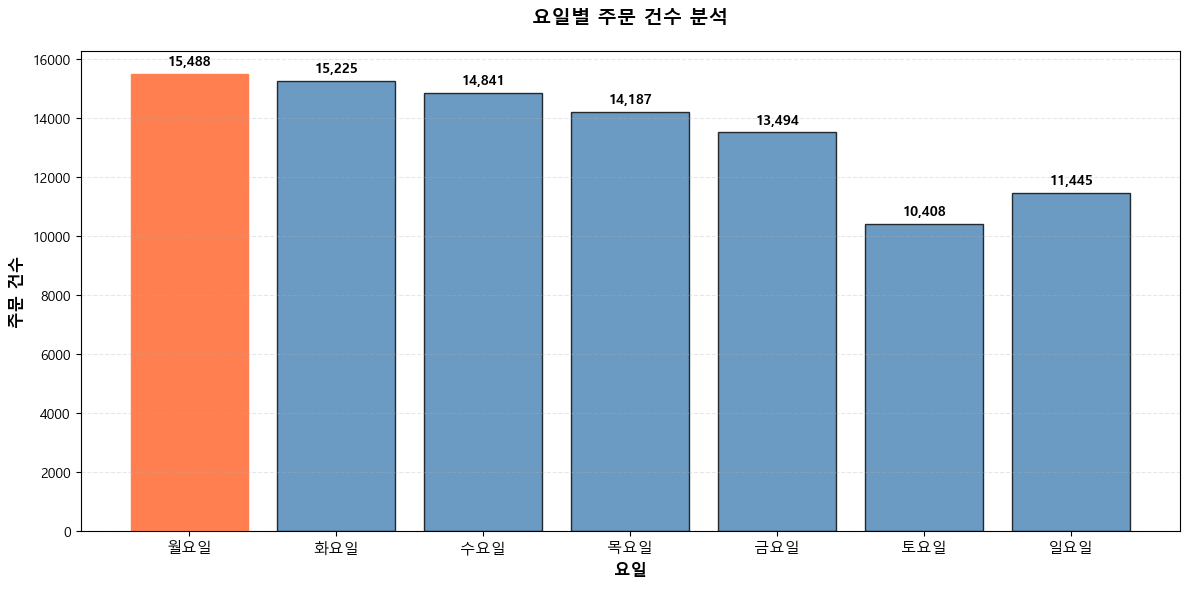


=== 요일별 주문 건수 ===
day_name
월요일    15488
화요일    15225
수요일    14841
목요일    14187
금요일    13494
토요일    10408
일요일    11445
Name: order_id, dtype: int64

가장 주문이 많은 요일: 월요일 (15,488건)
가장 주문이 적은 요일: 토요일 (10,408건)


In [27]:
# EDA  df_order

# order_status 컬럼의 각 값의 개수를 막대 그래프.
plt.figure(figsize=(10, 6))
sns.countplot(data=df_order, y='order_status', order=df_order['order_status'].value_counts().index)
plt.title('주문 상태(Order Status)별 개수', fontsize=15)
plt.xlabel('개수 (Count)', fontsize=12)
plt.ylabel('주문 상태', fontsize=12)
plt.show()

# 1. 날짜/시간 관련 컬럼들을 datetime 타입으로 변환
# errors='coerce'는 변환 중 오류 발생 시 해당 값을 NaT(Not a Time)으로 처리
time_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for col in time_cols:
    df_order[col] = pd.to_datetime(df_order[col], errors='coerce')

# 2. '주문 시간(hour)'을 추출하여 히스토그램
plt.figure(figsize=(12, 6))
df_order['order_purchase_timestamp'].dt.hour.hist(bins=24, rwidth=0.8) # 24시간을 기준으로
plt.title('시간대별 주문 분포', fontsize=15)
plt.xlabel('주문 시간 (Hour)', fontsize=12)
plt.ylabel('주문 건수 (Frequency)', fontsize=12)
plt.xticks(range(0, 24)) # x축 눈금을 0부터 23까지 표시
plt.grid(axis='y', alpha=0.7)
plt.show()

# 날짜 차이 계산 (일 단위)
df_order['purchase_to_approved'] = (df_order['order_approved_at'] - df_order['order_purchase_timestamp']).dt.total_seconds() / 86400
df_order['approved_to_carrier'] = (df_order['order_delivered_carrier_date'] - df_order['order_approved_at']).dt.total_seconds() / 86400
df_order['carrier_to_customer'] = (df_order['order_delivered_customer_date'] - df_order['order_delivered_carrier_date']).dt.total_seconds() / 86400
df_order['purchase_to_estimated'] = (df_order['order_estimated_delivery_date'] - df_order['order_purchase_timestamp']).dt.total_seconds() / 86400

# 시각화 (2행 2열)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df_order['purchase_to_approved'].hist(bins=30, ax=axes[0,0], color='skyblue')
axes[0,0].set_title('구매 → 승인까지 소요시간 (일)')

df_order['approved_to_carrier'].hist(bins=30, ax=axes[0,1], color='salmon')
axes[0,1].set_title('승인 → 택배사 전달까지 소요시간 (일)')

df_order['carrier_to_customer'].hist(bins=30, ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('배송 시작 → 고객 수령까지 소요시간 (일)')

df_order['purchase_to_estimated'].hist(bins=30, ax=axes[1,1], color='orange')
axes[1,1].set_title('구매 → 예상 배송일까지 (일)')

plt.tight_layout()
plt.show()


# order_purchase_timestamp를 datetime으로 변환
df_order['order_purchase_timestamp'] = pd.to_datetime(df_order['order_purchase_timestamp'])

# 요일 추출 (0=월요일, 6=일요일)
df_order['day_of_week'] = df_order['order_purchase_timestamp'].dt.dayofweek

# 요일명 매핑
day_names = {0: '월요일', 1: '화요일', 2: '수요일', 3: '목요일', 
             4: '금요일', 5: '토요일', 6: '일요일'}
df_order['day_name'] = df_order['day_of_week'].map(day_names)

# 요일별 주문 건수 집계
day_orders = df_order.groupby('day_name')['order_id'].nunique().reindex(day_names.values())

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(day_orders)), day_orders.values, 
               color='steelblue', alpha=0.8, edgecolor='black')

# 가장 많은 요일 강조
max_idx = day_orders.values.argmax()
bars[max_idx].set_color('coral')
bars[max_idx].set_alpha(1.0)

plt.xlabel('요일', fontsize=12, fontweight='bold')
plt.ylabel('주문 건수', fontsize=12, fontweight='bold')
plt.title('요일별 주문 건수 분석', fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(len(day_orders)), day_orders.index, fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# 막대 위에 값 표시
for i, v in enumerate(day_orders.values):
    plt.text(i, v + 200, f'{v:,}', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 통계 정보 출력
print("\n=== 요일별 주문 건수 ===")
print(day_orders)
print(f"\n가장 주문이 많은 요일: {day_orders.idxmax()} ({day_orders.max():,}건)")
print(f"가장 주문이 적은 요일: {day_orders.idxmin()} ({day_orders.min():,}건)")

In [13]:
# df_orders 이상치 확인 및 삭제 처리, 컬럼 추가

# 1. approved → carrier 음수
df_order['time_approved_to_carrier'] = (
    pd.to_datetime(df_order['order_delivered_carrier_date']) - 
    pd.to_datetime(df_order['order_approved_at'])
).dt.total_seconds() / 86400

negative_2 = (df_order['time_approved_to_carrier'] < 0).sum()
print(f"⚠️ approved → carrier 음수: {negative_2}건 <- 이상치 삭제 필요")

# 2. carrier → customer 음수
df_order['time_carrier_to_customer'] = (
    pd.to_datetime(df_order['order_delivered_customer_date']) - 
    pd.to_datetime(df_order['order_delivered_carrier_date'])
).dt.total_seconds() / 86400

negative_3 = (df_order['time_carrier_to_customer'] < 0).sum()
print(f"⚠️ carrier → customer 음수: {negative_3}건 <- 이상치 삭제 필요")

# 3. 이상치 제거
df_order = df_order[
    (df_order['time_approved_to_carrier'] >= 0) &
    (df_order['time_carrier_to_customer'] >= 0)
]

print(f"\n✅ 이상치 제거 후 행 수: {len(df_order)}")

# 배달 완료 데이터 기준, 배달이 정시에 도착했는지 확인용 컬럼 on_time 추가
# on_time 컬럼 추가 (실제 배달일 <= 예상 배달일이면 True)
# df_order['on_time'] = (
#     pd.to_datetime(df_order['order_delivered_customer_date']) <= 
#     pd.to_datetime(df_order['order_estimated_delivery_date'])
# )

# # 결과 확인 (배달 완료 건수만)
# delivered_orders = df_order[df_order['order_status'] == 'delivered']
# print("배달 완료 건수:", len(delivered_orders))
# print("\n배송 성과:")
# print(delivered_orders['on_time'].value_counts())
# print(f"\n정시 배송률: {delivered_orders['on_time'].mean():.2%}")

# # 지연일 계산 (출력용)
# delay_days = (
#     pd.to_datetime(delivered_orders['order_delivered_customer_date']) - 
#     pd.to_datetime(delivered_orders['order_estimated_delivery_date'])
# ).dt.total_seconds() / 86400
# print(f"평균 지연일: {delay_days.mean():.1f}일")

⚠️ approved → carrier 음수: 1359건 <- 이상치 삭제 필요
⚠️ carrier → customer 음수: 23건 <- 이상치 삭제 필요

✅ 이상치 제거 후 행 수: 95088


In [14]:
# 이상치 탐지 
df_order_items.describe() # 음수 없음

# 0값 탐지
df_combined_outliers = df_order_items[(df_order_items['price'] == 0) | (df_order_items['freight_value'] == 0)]
print(len(df_combined_outliers))

# 결측률 확인
zero_rate = (df_order_items[['price','freight_value']] == 0).mean()
print(zero_rate)

383
price            0.0000
freight_value    0.0034
dtype: float64


📌 피어슨 상관계수:
                   price  freight_value
price          1.000000       0.414204
freight_value  0.414204       1.000000

📌 스피어맨 상관계수:
                  price  freight_value
price          1.00000        0.43419
freight_value  0.43419        1.00000


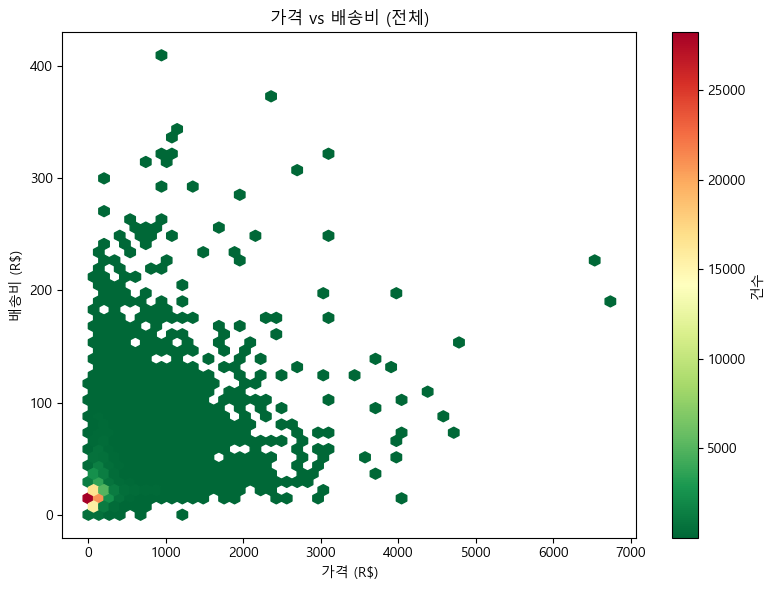

전체 데이터 행 수: 112650
IsolationForest 모델이 탐지한 이상치 개수: 1127
이상치 비율: 1.0004438526409232 %


In [15]:
# df_order_items 가격과 배송료 상관관계

# 1) 기본 상관관계 확인
corr_pearson = df_order_items[['price','freight_value']].corr(method='pearson')
corr_spearman = df_order_items[['price','freight_value']].corr(method='spearman')

print("📌 피어슨 상관계수:\n", corr_pearson)
print("\n📌 스피어맨 상관계수:\n", corr_spearman)

# 2) 시각화
plt.figure(figsize=(8, 6))
hb = plt.hexbin(df_order_items['price'], df_order_items['freight_value'], 
                gridsize=50, cmap='RdYlGn_r', mincnt=1)
plt.title('가격 vs 배송비 (전체)')
plt.xlabel('가격 (R$)')
plt.ylabel('배송비 (R$)')
plt.colorbar(hb, label='건수')
plt.tight_layout()
plt.show()

# 3) IsolationForest로 이상치 탐지
iso = IsolationForest(contamination=0.01, random_state=42)
df_order_items['outlier'] = iso.fit_predict(df_order_items[['price','freight_value']])

# 예측 결과를 'outlier_preds'라는 별도 변수에 저장
outlier_preds = iso.fit_predict(df_order_items[['price','freight_value']])

# 저장된 변수를 사용해 이상치 정보를 출력
print("전체 데이터 행 수:", len(df_order_items))
print("IsolationForest 모델이 탐지한 이상치 개수:", (outlier_preds == -1).sum())
print("이상치 비율:", (outlier_preds == -1).mean()*100, "%")


In [16]:
'''
df_order_items 컬럼 추가(기준: 결제완료 건)
'item_total' id별 
'freight_total': id별 
'order_total' : id별, 'item_total' + 'freight_total'
'order_total' : 전체 총 매출
'''

# order_id별 집계
df_order_items['item_count'] = df_order_items.groupby('order_id')['order_item_id'].transform('count')
df_order_items['item_total'] = df_order_items.groupby('order_id')['price'].transform('sum')
df_order_items['freight_total'] = df_order_items.groupby('order_id')['freight_value'].transform('sum')
df_order_items['order_total'] = df_order_items['item_total'] + df_order_items['freight_total']

df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
 7   outlier              112650 non-null  int64  
 8   item_count           112650 non-null  int64  
 9   item_total           112650 non-null  float64
 10  freight_total        112650 non-null  float64
 11  order_total          112650 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 10.3+ MB


In [17]:
'''
df_order_reviews 전처리

- 전처리 전 
review_comment_title: 결측치 88% → 고객 대부분이 제목은 아예 작성하지 않음.
review_comment_message: 결측치 59% → 절반 이상이 코멘트를 남기지 않음.
review_score → 전부 존재
- 전처리 후
타이틀 작성, 코멘트 작성 컬럼 추가
'''
# 목적: 배송 지연 ↔ 리뷰 점수, 텍스트 작성 여부 분석

# 1. 플래그 추가
df_order_reviews['has_title'] = df_order_reviews['review_comment_title'].notna()
df_order_reviews['has_comment'] = df_order_reviews['review_comment_message'].notna()

# 2. 현황 확인
print("✅ 전처리 완료")
print(f"전체 리뷰: {len(df_order_reviews):,}개")
print(f"제목 있음: {df_order_reviews['has_title'].sum():,}개 ({df_order_reviews['has_title'].mean()*100:.1f}%)")
print(f"코멘트 있음: {df_order_reviews['has_comment'].sum():,}개 ({df_order_reviews['has_comment'].mean()*100:.1f}%)")

✅ 전처리 완료
전체 리뷰: 99,224개
제목 있음: 11,568개 (11.7%)
코멘트 있음: 40,977개 (41.3%)


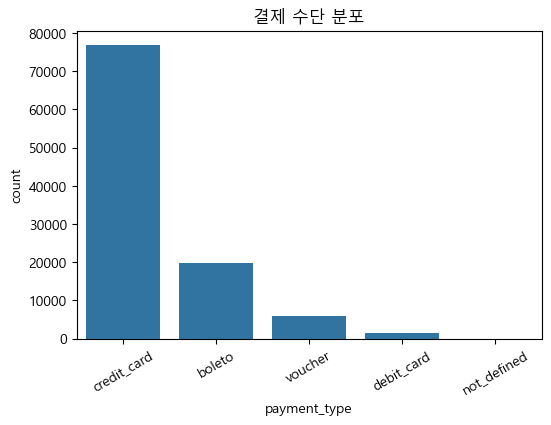


[결제 수단 비율]
payment_type
credit_card    0.739
boleto         0.190
voucher        0.056
debit_card     0.015
not_defined    0.000
Name: proportion, dtype: float64


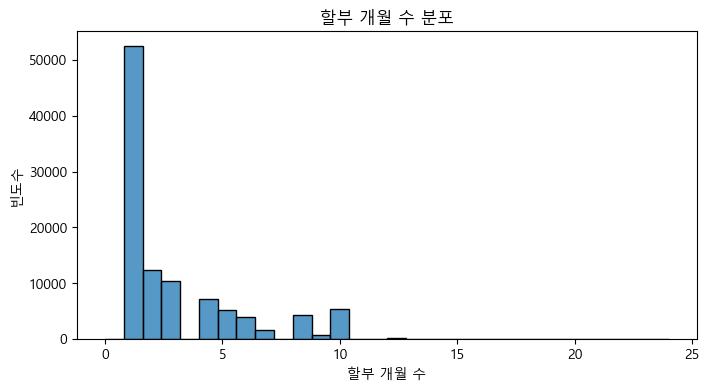


[할부 개월 수 통계]
count    103886.000000
mean          2.853349
std           2.687051
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64


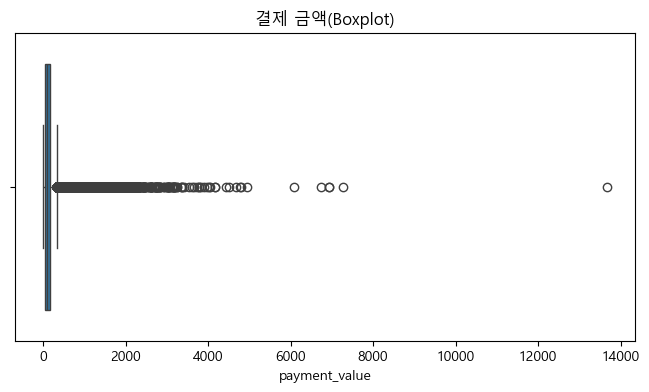

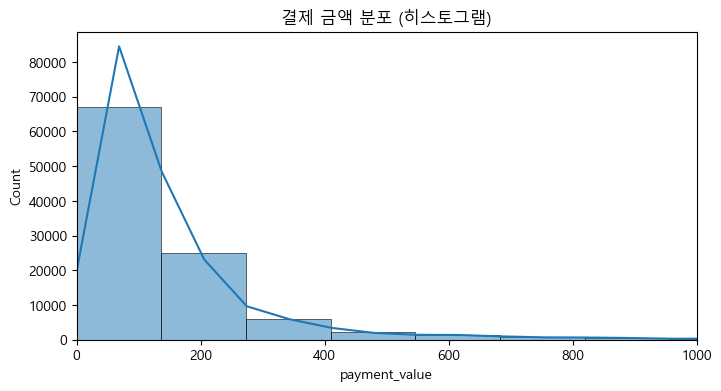


[결제 금액 통계]
count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64
결제금액 0원 비율: 0.01%


In [18]:
# df_order_payments: 결측X, 이상치 탐지

# 1. payment_type 분포 확인
plt.figure(figsize=(6,4))
sns.countplot(data=o_df_order_payments, x='payment_type', order=o_df_order_payments['payment_type'].value_counts().index)
plt.title("결제 수단 분포")
plt.xticks(rotation=30)
plt.show()

print("\n[결제 수단 비율]")
print(o_df_order_payments['payment_type'].value_counts(normalize=True).round(3))

# 2. 할부 개월 수 분포
plt.figure(figsize=(8,4))
sns.histplot(o_df_order_payments['payment_installments'], bins=30, kde=False)
plt.title("할부 개월 수 분포")
plt.xlabel("할부 개월 수")
plt.ylabel("빈도수")
plt.show()

print("\n[할부 개월 수 통계]")
print(o_df_order_payments['payment_installments'].describe())

# 3. 결제 금액 분포 (payment_value)
plt.figure(figsize=(8,4))
sns.boxplot(x=o_df_order_payments['payment_value'])
plt.title("결제 금액(Boxplot)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(o_df_order_payments['payment_value'], bins=100, kde=True)
plt.title("결제 금액 분포 (히스토그램)")
plt.xlim(0, 1000)  # 고액 결제는 따로 확인하기 위해 일단 1000 이하만 시각화
plt.show()

print("\n[결제 금액 통계]")
print(o_df_order_payments['payment_value'].describe())

# 결제금액 0달러 비율: 0.01%
zero_payment_ratio = (df_order_payments['payment_value'] == 0).mean()
print(f"결제금액 0원 비율: {zero_payment_ratio:.2%}")

# 결제금액 == 0 and 결제방법 확인
df_order_payments[df_order_payments['payment_value'] == 0]['payment_type'].value_counts()

# 이상치 처리: 결제금액 == 0 and 결제방법=not dine 3건 삭제
df_order_payments = df_order_payments[df_order_payments['payment_type'] != 'not_defined']


# merge

In [19]:
### point: 구매 고객만 남김



#RFM

In [20]:
# 배송 완료된 주문만 먼저 필터링
df_order_delivered = df_order[df_order['order_status'] == 'delivered']

# 1) customer + order (구매 고객만)
merge_co = df_customers.merge(
    df_order_delivered,
    on="customer_id",
    how="inner",
    validate="1:m"
)

# 2) + order_items
merge_coi = merge_co.merge(
    df_order_items,
    on="order_id",
    how="left",
    validate="1:m"
)

# 3) + geolocation
merge_coig = merge_coi.merge(
    df_geolocation.drop_duplicates(
        subset="geolocation_zip_code_prefix",
        keep='first'
    ),
    left_on="customer_zip_code_prefix",
    right_on="geolocation_zip_code_prefix",
    how="left",
    validate="m:1"
)

# 4) + payments
df_payments = df_order_payments.groupby('order_id')['payment_value'].sum().reset_index()

merge_coigp = merge_coig.merge(
    df_payments,
    on="order_id",
    how="left",
    validate="m:1"  
)

merge_coigp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108581 entries, 0 to 108580
Data columns (total 35 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    108581 non-null  object        
 1   customer_unique_id             108581 non-null  object        
 2   customer_zip_code_prefix       108581 non-null  int64         
 3   customer_city                  108581 non-null  object        
 4   customer_state                 108581 non-null  object        
 5   order_id                       108581 non-null  object        
 6   order_status                   108581 non-null  object        
 7   order_purchase_timestamp       108581 non-null  datetime64[ns]
 8   order_approved_at              108581 non-null  datetime64[ns]
 9   order_delivered_carrier_date   108581 non-null  datetime64[ns]
 10  order_delivered_customer_date  108581 non-null  datetime64[ns]
 11  

# RFM

In [21]:
today_date = merge_coigp['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

rfm = (
    merge_coigp.groupby('customer_unique_id')
    .agg({
        'order_purchase_timestamp': lambda x: (today_date - x.max()).days,
        'order_id': 'nunique',
        'payment_value': 'sum'
    })
    .rename(columns={
        'order_purchase_timestamp': 'Recency',
        'order_id': 'Frequency',
        'payment_value': 'Monetary'
    })
    .reset_index()
)

# 점수화
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop').astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5], duplicates='drop').astype(int)
rfm['F_score'] = np.select(
    [rfm['Frequency']==1, rfm['Frequency']==2, rfm['Frequency']==3, 
     rfm['Frequency'].between(4,5), rfm['Frequency']>=6],
    [1, 2, 3, 4, 5], default=1
).astype(int)

rfm['RFM_Score'] = rfm['R_score'] + rfm['F_score'] + rfm['M_score']

# 세그먼트 분류 
rfm['Segment'] = np.select(
    [
        (rfm['R_score']>=4) & (rfm['F_score']>=4) & (rfm['M_score']>=4),  # VIP
        (rfm['F_score']>=4) & (rfm['R_score']>=3) & (rfm['M_score']>=3),  # 충성고객
        (rfm['R_score']>=4) & (rfm['M_score']>=4) & (rfm['F_score']<4),   # 잠재우수
        (rfm['R_score']>=4) & (rfm['F_score']==1),                         # 신규고객
        (rfm['R_score']<=2) & (rfm['F_score']>=3),                         # 이탈위험
        (rfm['R_score']<=2) & (rfm['F_score']==2),                         # 주의고객
        (rfm['R_score']>=3) & (rfm['F_score']<=2) & (rfm['M_score']<=3),  # 관심고객
        (rfm['R_score']==1) & (rfm['F_score']==1)                          # 이탈고객
    ],
    ['VIP', '충성고객', '잠재우수', '신규고객', '이탈위험', '주의고객', '관심고객', '이탈고객'],
    default='일반고객'
)

           고객수    평균구매액         총매출  평균Recency  평균Frequency  고객비율(%)  매출비율(%)  \
Segment                                                                         
일반고객     25067   268.74  6736490.45     290.73         1.02    27.24    34.54   
잠재우수     15143   418.28  6333981.06      93.39         1.07    16.46    32.47   
이탈고객     17897   195.39  3496975.44     474.72         1.00    19.45    17.93   
신규고객     21499    75.18  1616218.95      91.98         1.00    23.36     8.29   
관심고객     11417    75.09   857289.59     220.57         1.03    12.41     4.40   
주의고객       896   395.71   354551.93     383.42         2.00     0.97     1.82   
VIP         32  1859.05    59489.55      85.59         4.97     0.03     0.31   
이탈위험        68   633.79    43097.55     394.85         3.15     0.07     0.22   
충성고객         6  1075.74     6454.43     211.00         5.83     0.01     0.03   

           효율성  
Segment         
일반고객      1.27  
잠재우수      1.97  
이탈고객      0.92  
신규고객      0.35  
관심고객  

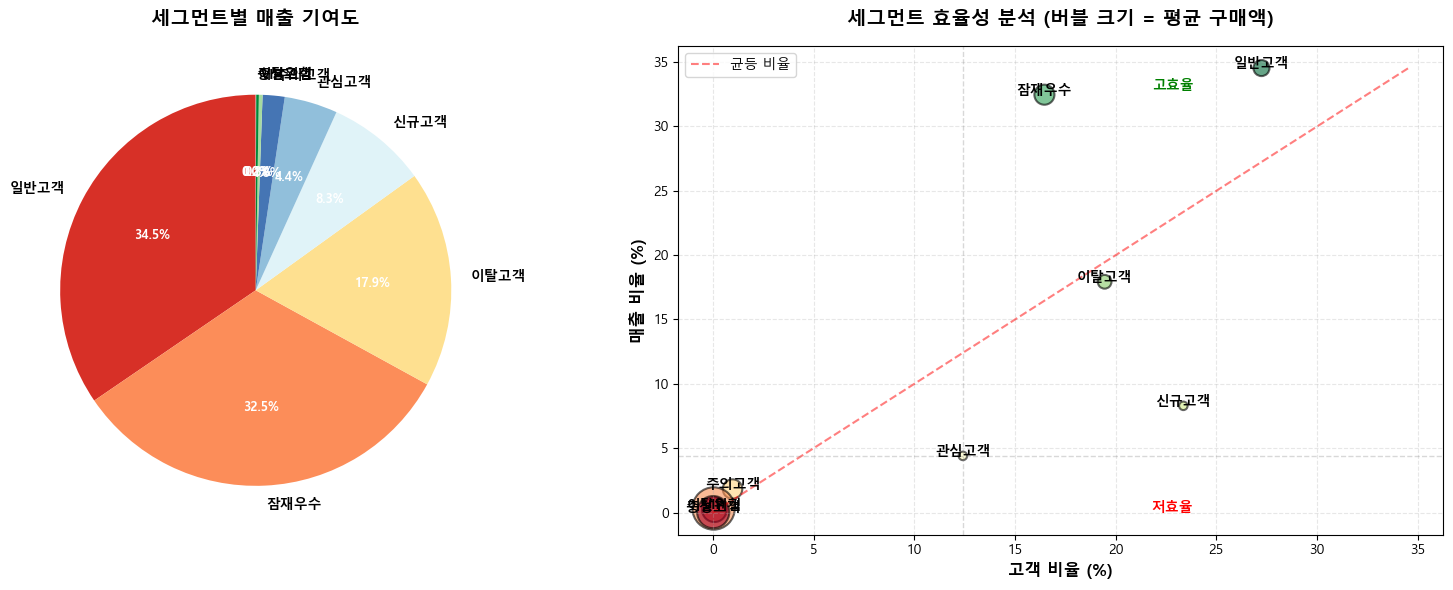

In [22]:
# 세그먼트별 매출 기여도

# 세그먼트별 집계
segment_stats = rfm.groupby('Segment').agg({
    'customer_unique_id': 'count',
    'Monetary': ['mean', 'sum'],
    'Recency': 'mean',
    'Frequency': 'mean'
}).round(2)

segment_stats.columns = ['고객수', '평균구매액', '총매출', '평균Recency', '평균Frequency']
segment_stats['고객비율(%)'] = (segment_stats['고객수'] / segment_stats['고객수'].sum() * 100).round(2)
segment_stats['매출비율(%)'] = (segment_stats['총매출'] / segment_stats['총매출'].sum() * 100).round(2)
segment_stats['효율성'] = (segment_stats['매출비율(%)'] / segment_stats['고객비율(%)']).round(2)
segment_stats = segment_stats.sort_values('총매출', ascending=False)

print(segment_stats)

# ==================== 마케팅 우선순위 결정 ====================
# 우선순위 로직
priorities = []

for segment in segment_stats.index:
    stats = segment_stats.loc[segment]
    
    # 우선순위 점수 계산 (매출비율 + 효율성 + 고객수)
    priority_score = (
    stats['매출비율(%)'] * 0.4 +     # 영향력 40%
    (stats['효율성'] / stats['효율성'].max() * 100) * 0.3 +   # 효율성 표준화
    (stats['고객수'] / stats['고객수'].max() * 100) * 0.3      # 고객수 표준화
)
    
    # 세그먼트 특성에 따른 전략
    if segment == 'VIP':
        priority = 1
    elif segment == '충성고객':
        priority = 2
    elif segment == '잠재우수':
        priority = 3
    elif segment == '이탈위험':
        priority = 4
    elif segment == '신규고객':
        priority = 5
    elif segment == '주의고객':
        priority = 6
    elif segment == '관심고객':
        priority = 7
    elif segment == '이탈고객':
        priority = 8
    else:  # 일반고객
        priority = 9
    
    priorities.append({
        '세그먼트': segment,
        '우선순위': priority,
        '우선순위점수': round(priority_score, 2),
        '고객수': int(stats['고객수']),
        '매출기여': f"{stats['매출비율(%)']}%",
        '효율성': f"{stats['효율성']}배"
    })

# 우선순위 정렬
priorities_df = pd.DataFrame(priorities).sort_values('우선순위')

# print("\n" + "-"*90)
# for _, row in priorities_df.iterrows():
#     print(f"\n[{row['우선순위']}순위] {row['세그먼트']} (점수: {row['우선순위점수']})")
#     print(f"  • 규모: {row['고객수']:,}명")
#     print(f"  • 매출 기여: {row['매출기여']} (효율성 {row['효율성']})")
#     print(f"  • 전략: {row['전략']}")

#시각화 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4', '#a6dba0', '#008837', '#c7eae5']
wedges, texts, autotexts = ax1.pie(
    segment_stats['총매출'],
    labels=segment_stats.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors[:len(segment_stats)],
    textprops={'fontsize': 10, 'weight': 'bold'}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)

ax1.set_title('세그먼트별 매출 기여도', fontsize=14, fontweight='bold', pad=15)

# 2) 우선순위별 투자 가치 (매출 기여도 vs 고객 수)
ax2 = axes[1]
x = segment_stats['고객비율(%)']
y = segment_stats['매출비율(%)']
sizes = segment_stats['평균구매액'] / 2

scatter = ax2.scatter(x, y, s=sizes, alpha=0.6, c=range(len(segment_stats)), cmap='RdYlGn_r', edgecolors='black', linewidth=1.5)

for i, segment in enumerate(segment_stats.index):
    ax2.annotate(segment, (x.iloc[i], y.iloc[i]), fontsize=10, fontweight='bold', ha='center')

max_val = max(x.max(), y.max())
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=1.5, alpha=0.5, label='균등 비율')

# 효율성 영역 표시
ax2.axhline(y.median(), color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax2.axvline(x.median(), color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax2.text(x.max()*0.8, y.max()*0.95, '고효율', fontsize=10, color='green', fontweight='bold')
ax2.text(x.max()*0.8, y.min()*1.5, '저효율', fontsize=10, color='red', fontweight='bold')

ax2.set_xlabel('고객 비율 (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('매출 비율 (%)', fontsize=12, fontweight='bold')
ax2.set_title('세그먼트 효율성 분석 (버블 크기 = 평균 구매액)', fontsize=14, fontweight='bold', pad=15)
ax2.grid(alpha=0.3, linestyle='--')
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [23]:
# 파레토 법칙 확인

# 1) 고객별 매출 기준으로 정렬
total_customers = len(rfm)
total_revenue = rfm['Monetary'].sum()

# 매출 높은 순으로 정렬하여 누적 계산
sorted_monetary = rfm['Monetary'].sort_values(ascending=False).reset_index(drop=True)
cumulative_revenue = sorted_monetary.cumsum()
cumulative_revenue_pct = (cumulative_revenue / total_revenue * 100).round(2)

# 2) 상위 20% 고객이 차지하는 매출 비율
top_20_customer_count = int(total_customers * 0.2)
top_20_revenue = cumulative_revenue.iloc[top_20_customer_count - 1]
top_20_revenue_pct = (top_20_revenue / total_revenue * 100).round(2)

print(f"\n✅ 전체 고객: {total_customers:,}명")
print(f"✅ 전체 매출: {total_revenue:,.2f}원")
print(f"\n🎯 상위 20% 고객 ({top_20_customer_count:,}명) → 매출 {top_20_revenue_pct}% 차지")



✅ 전체 고객: 92,025명
✅ 전체 매출: 19,504,548.95원

🎯 상위 20% 고객 (18,405명) → 매출 61.75% 차지



📊 세그먼트별 이탈 리텐션 분석 (Recency 기반)
           고객수  평균Recency  평균주문    평균구매액         총매출  이탈위험도      예상회복매출  \
Segment                                                                   
이탈고객     17897     474.72  1.00   195.39  3496975.44   4.75  3496894.83   
일반고객     25067     290.73  1.02   268.74  6736490.45   2.91  6736505.58   
이탈위험        68     394.85  3.15   633.79    43097.55   3.95    43097.72   
주의고객       896     383.42  2.00   395.71   354551.93   3.83   354556.16   
관심고객     11417     220.57  1.03    75.09   857289.59   2.21   857302.53   
충성고객         6     211.00  5.83  1075.74     6454.43   2.11     6454.44   
잠재우수     15143      93.39  1.07   418.28  6333981.06   0.93  6334014.04   
신규고객     21499      91.98  1.00    75.18  1616218.95   0.92  1616294.82   
VIP         32      85.59  4.97  1859.05    59489.55   0.86    59489.60   

         회복률(%)  우선순위점수  
Segment                  
이탈고객      100.0  226.99  
일반고객      100.0  176.40  
이탈위험      100.0  158.27  
주의고객      10

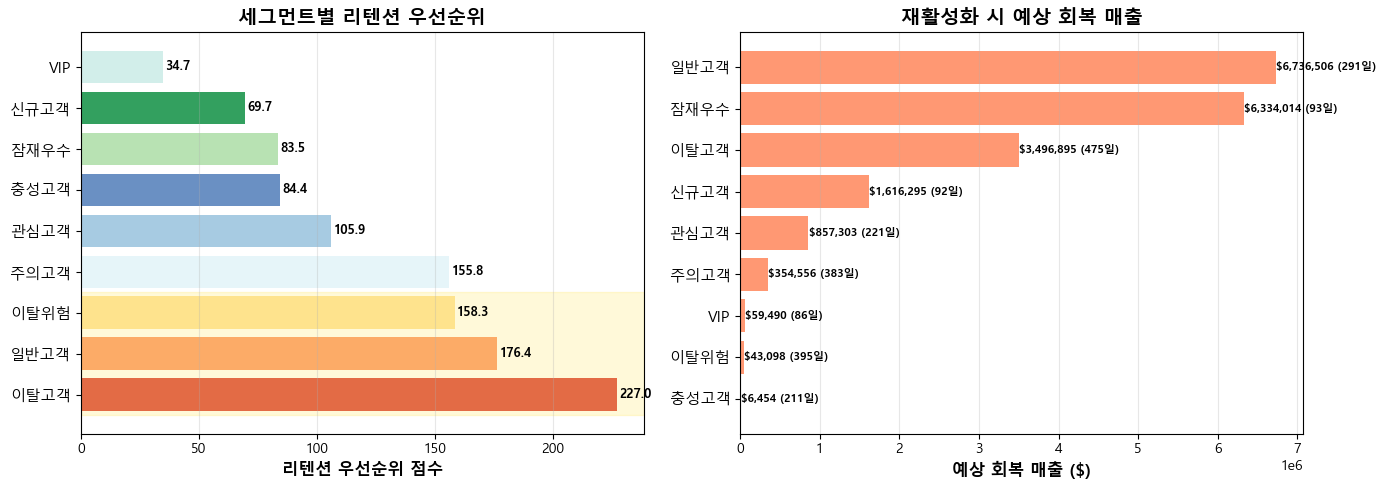


💡 결론
⚠️  '이탈고객' 세그먼트 긴급 리텐션 필요
   • 17897명, 평균 475일 경과
   • 재활성화 시 $3,496,895 매출 회복 가능
✅ 전략: 즉시 재구매 쿠폰, 리타겟팅 광고, 1:1 상담


In [24]:
# 이탈 리텐션 분석 (Recency 기반)

# 세그먼트별 Recency 통계
segment_recency = rfm.groupby('Segment').agg({
    'customer_unique_id': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'sum']
}).round(2)

segment_recency.columns = ['고객수', '평균Recency', '평균주문', '평균구매액', '총매출']

# 이탈 위험도 (Recency 높을수록 위험)
segment_recency['이탈위험도'] = (segment_recency['평균Recency'] / 100).round(2)

# 재활성화 시 예상 매출 회복 (1회 재구매 가정)
segment_recency['예상회복매출'] = (segment_recency['고객수'] * segment_recency['평균구매액']).round(2)
segment_recency['회복률(%)'] = (segment_recency['예상회복매출'] / segment_recency['총매출'] * 100).round(2)

# 리텐션 우선순위 점수 (이탈위험 40% + 회복매출 30% + 고객규모 30%)
segment_recency['우선순위점수'] = (
    segment_recency['이탈위험도'] * 100 * 0.4 +
    (segment_recency['예상회복매출'] / segment_recency['예상회복매출'].max() * 100) * 0.3 +
    (segment_recency['고객수'] / segment_recency['고객수'].max() * 100) * 0.3
).round(2)

segment_recency = segment_recency.sort_values('우선순위점수', ascending=False)

# 결과 출력
print("\n" + "="*90)
print("📊 세그먼트별 이탈 리텐션 분석 (Recency 기반)")
print("="*90)
print(segment_recency)

print("\n" + "="*90)
print("🚨 리텐션 우선순위 TOP 3")
print("="*90)

for idx, (segment, row) in enumerate(segment_recency.head(3).iterrows(), 1):
    print(f"\n[{idx}순위] {segment}")
    print(f"  고객수: {row['고객수']:.0f}명 | 평균 Recency: {row['평균Recency']:.0f}일")
    print(f"  이탈위험도: {row['이탈위험도']:.2f} | 재활성화 시 → ${row['예상회복매출']:,.0f} 회복 가능")
    print(f"  우선순위점수: {row['우선순위점수']}")


# ==================== 시각화 ====================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) 리텐션 우선순위 랭킹
ax1 = axes[0]
colors = ['#d73027', '#fc8d59', '#fee090', '#e0f3f8', '#91bfdb', '#4575b4', '#a6dba0', '#008837', '#c7eae5']
bars = ax1.barh(range(len(segment_recency)), segment_recency['우선순위점수'], 
                color=colors[:len(segment_recency)], alpha=0.8)

ax1.set_yticks(range(len(segment_recency)))
ax1.set_yticklabels(segment_recency.index, fontsize=11)
ax1.set_xlabel('리텐션 우선순위 점수', fontsize=12, fontweight='bold')
ax1.set_title('세그먼트별 리텐션 우선순위', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Top 3 강조
ax1.axhspan(-0.5, 2.5, alpha=0.15, color='gold')

for i, score in enumerate(segment_recency['우선순위점수']):
    ax1.text(score + 1, i, f'{score:.1f}', va='center', fontsize=9, fontweight='bold')

# 2) 예상 회복 매출
ax2 = axes[1]
sorted_recovery = segment_recency.sort_values('예상회복매출', ascending=True)
bars = ax2.barh(range(len(sorted_recovery)), sorted_recovery['예상회복매출'], 
                color='coral', alpha=0.8)

ax2.set_yticks(range(len(sorted_recovery)))
ax2.set_yticklabels(sorted_recovery.index, fontsize=11)
ax2.set_xlabel('예상 회복 매출 ($)', fontsize=12, fontweight='bold')
ax2.set_title('재활성화 시 예상 회복 매출', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (revenue, days) in enumerate(zip(sorted_recovery['예상회복매출'], sorted_recovery['평균Recency'])):
    ax2.text(revenue + 500, i, f'${revenue:,.0f} ({days:.0f}일)', 
            va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

# 최종 요약
print("\n" + "="*90)
print("💡 결론")
print("="*90)
top1 = segment_recency.index[0]
top1_customers = segment_recency.iloc[0]['고객수']
top1_recency = segment_recency.iloc[0]['평균Recency']
top1_recovery = segment_recency.iloc[0]['예상회복매출']
print(f"⚠️  '{top1}' 세그먼트 긴급 리텐션 필요")
print(f"   • {top1_customers:.0f}명, 평균 {top1_recency:.0f}일 경과")
print(f"   • 재활성화 시 ${top1_recovery:,.0f} 매출 회복 가능")
print(f"✅ 전략: 즉시 재구매 쿠폰, 리타겟팅 광고, 1:1 상담")

                  고객수         총매출   1인당매출
customer_state                           
SP              38584  7302116.73  189.25
RJ              11785  2657534.99  225.50
MG              10838  2249422.51  207.55
RS               5086  1090853.01  214.48
PR               4693  1015404.61  216.37
BA               3112   765620.96  246.02
SC               3395   757684.46  223.18
GO               1864   485759.02  260.60
DF               1981   412775.98  208.37
ES               1903   393460.11  206.76


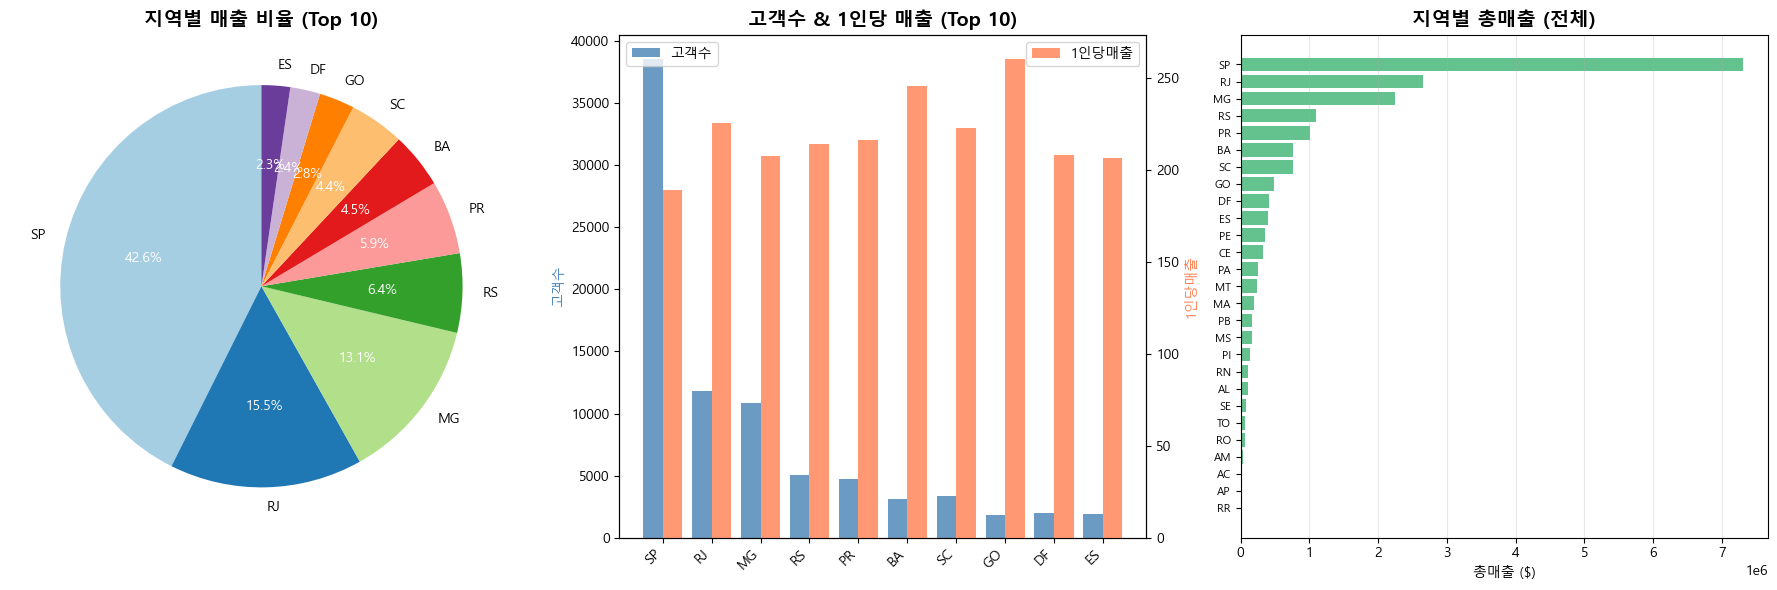

In [25]:
# 지역별 매출 분석
지역매출 = merge_coigp.groupby('customer_state').agg({
    'customer_unique_id': 'nunique',
    'payment_value': 'sum'
})
지역매출.columns = ['고객수', '총매출']
지역매출['1인당매출'] = (지역매출['총매출'] / 지역매출['고객수']).round(2)

# Top 10 (파이차트, 고객수 차트용)
지역매출_top10 = 지역매출.sort_values('총매출', ascending=False).head(10)

# 전체 지역 (막대그래프용)
지역매출_전체 = 지역매출.sort_values('총매출', ascending=False)

print(지역매출_top10)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) 매출 비율 파이차트 (Top 10)
wedges, texts, autotexts = axes[0].pie(
    지역매출_top10['총매출'], labels=지역매출_top10.index, autopct='%1.1f%%',
    startangle=90, colors=plt.cm.Paired(range(len(지역매출_top10)))
)
for autotext in autotexts:
    autotext.set_color('white')
axes[0].set_title('지역별 매출 비율 (Top 10)', fontsize=14, fontweight='bold')

# 2) 고객수 & 1인당 매출 (Top 10)
ax2_twin = axes[1].twinx()
x = range(len(지역매출_top10))

axes[1].bar([i-0.2 for i in x], 지역매출_top10['고객수'], 0.4, label='고객수', alpha=0.8, color='steelblue')
ax2_twin.bar([i+0.2 for i in x], 지역매출_top10['1인당매출'], 0.4, label='1인당매출', alpha=0.8, color='coral')

axes[1].set_xticks(x)
axes[1].set_xticklabels(지역매출_top10.index, rotation=45, ha='right')
axes[1].set_ylabel('고객수', color='steelblue')
ax2_twin.set_ylabel('1인당매출', color='coral')
axes[1].set_title('고객수 & 1인당 매출 (Top 10)', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# 3) 총매출 막대그래프 (전체 지역)
axes[2].barh(range(len(지역매출_전체)), 지역매출_전체['총매출'], alpha=0.8, color='mediumseagreen')
axes[2].set_yticks(range(len(지역매출_전체)))
axes[2].set_yticklabels(지역매출_전체.index, fontsize=8)
axes[2].set_xlabel('총매출 ($)')
axes[2].set_title('지역별 총매출 (전체)', fontsize=14, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)
axes[2].invert_yaxis()  # 상위 지역이 위로

plt.tight_layout()
plt.show()